In [37]:
import numpy as np
from tqdm import tqdm
import gym
import math
import random
import matplotlib.pyplot as plt

In [38]:
env = gym.make('Taxi-v3')
num_actions = env.action_space
num_obs = env.observation_space
R, G, B, Y = env.unwrapped.locs
R, G, B, Y = list(R), list(G), list(B), list(Y)
env.reset()

(371, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

In [39]:
def get_state(state):
    row, col, pass_id, dest_id = env.unwrapped.decode(state)
    state = np.asarray([row,col,pass_id,dest_id])
    return state

print(R,G,B,Y)

[0, 0] [0, 4] [4, 0] [4, 3]


In [40]:
curr_state = get_state(env.s)
print("Taxi at",curr_state[0:2])
next_state, reward, done, _, _ = env.step(4)
row, col, pass_id, dest_id = env.unwrapped.decode(next_state)
print(curr_state[2])

Taxi at [3 3]
2


In [41]:
q_r = np.zeros((500,4))
q_b = np.zeros((500,4))
q_g = np.zeros((500,4))
q_y = np.zeros((500,4))
q = np.zeros((500,10))

In [42]:
# Set the number of episodes and maximum number of steps per episode
EPS = 10000
MAX_STEPS = 500
EXP = 1
# Set the learning rate, discount factor, and exploration rate
ALPHA = 0.1
GAMMA = 0.99
exploration_rate = 1.0
MIN_EXP = 0.01
EXP_DECAY = 0.01

In [43]:
# Four different q value functions for the four options
def choose_action_option(state,q_table):
    action = np.argmax(q_table[state])
    return action

def choose_action(q,state):
    if not q[state].any():
        return random.randint(0,10)
    action = np.argmax(q[state])
    
    if np.random.rand() < EXP:
        action = np.random.randint(0,10)
        return action
    return action

    

In [44]:
# Options where policy is greedy wrt the corresponding q Value function
def Red(q_r,state):
    optdone = False
    optact = choose_action_option(state,q_r)
    state = get_state(state)
    if state[0:2] is R:
        optdone = True
    return optact,optdone

def Green(q_g,state):
    optdone = False
    optact = choose_action_option(state,q_g)
    state = get_state(state)
    if state[0:2] is G:
        optdone = True
    return optact,optdone
    
def Yellow(q_y,state):
    optdone = False
    optact = choose_action_option(state,q_y)
    state = get_state(state)
    if state[0:2] is Y:
        optdone = True
    return optact,optdone 

def Blue(q_b,state):
    optdone = False
    optact = choose_action_option(state,q_b)
    state = get_state(state)
    if state[0:2] is B:
        optdone = True
    return optact,optdone 

In [45]:
def run():
 avg_reward = []
 for episode in range(300):
    running = 0
    state, _ = env.reset()
    done = False
    total_reward = 0
    ep_reward = 0
    
    steps = 0
    while not done and steps < 500:
        steps += 1
        action = choose_action(q,state)
        if action < 6:
            next_state, reward, done, _, _ = env.step(action)
            ep_reward+= reward
            q[state,action] = q[state, action] 
            + ALPHA * (reward + GAMMA * np.max(q[next_state, :])
                                                                  - q[state, action])
            total_reward += reward
            state = next_state
        
        reward_bar = 0
        if action > 5 and action < 10:
            count = 0
            optdone = False
            current_state = state
            while (optdone == False) and count < 100:
                if action == 6:
                    optact, optdone = Red(q_r,state) 
                    next_state, reward, done, _, _ = env.step(optact)
                    q_r[state,optact] = q_r[state, optact] 
                    + ALPHA * (reward + GAMMA * np.max(q_r[next_state, :])
                                                                  - q_r[state, optact])
                    
                if action == 7:
                    optact, optdone = Green(q_g,state)
                    next_state, reward, done, _, _ = env.step(optact)
                    q_g[state,optact] = q_g[state, optact] 
                    + ALPHA * (reward + GAMMA * np.max(q_g[next_state, :])
                                                                  - q_g[state, optact])
                    
                if action == 8:
                    optact, optdone = Blue(q_b,state)
                    
                    next_state, reward, done, _, _ = env.step(optact)
                    q_b[state,optact] = q_b[state, optact] 
                    + ALPHA * (reward + GAMMA * np.max(q_b[next_state, :])
                                                                  - q_b[state, optact])
                    
                if action == 9:
                    optact, optdone = Yellow(q_y,state)
                    next_state, reward, done, _, _ = env.step(optact)
                    q_y[state,optact] = q_y[state, optact] 
                    + ALPHA * (reward + GAMMA * np.max(q_y[next_state])
                                                                  - q_y[state, optact])
                    
                reward_bar = reward_bar + GAMMA*reward
                ep_reward += reward
                count += 1
                if optdone == True:
                    q[current_state, action] += ALPHA * (reward_bar 
                            - q[current_state, action] 
                            + GAMMA**count * np.max(q[next_state, :]))
                    print("DONE")
                state = next_state

    running = 0.05 * ep_reward + (1 - 0.05) * running
    avg_reward.append(running)
        

    # Decay the exploration rate
    EXP = MIN_EXP + (1 - MIN_EXP) * np.exp(-EXP_DECAY * episode)

    # Print the total reward for each episode
    print(f"Episode {episode + 1}: Total Reward = {running}")
 return avg_reward


In [46]:
k = run()

Episode 1: Total Reward = -952.35
Episode 2: Total Reward = -926.4000000000001
Episode 3: Total Reward = -923.1
Episode 4: Total Reward = -978.1500000000001
Episode 5: Total Reward = -909.6500000000001
Episode 6: Total Reward = -988.7
Episode 7: Total Reward = -978.2
Episode 8: Total Reward = -990.2
Episode 9: Total Reward = -973.6500000000001
Episode 10: Total Reward = -957.6
Episode 11: Total Reward = -842.0500000000001
Episode 12: Total Reward = -859.95
Episode 13: Total Reward = -1031.15
Episode 14: Total Reward = -960.0
Episode 15: Total Reward = -997.1
Episode 16: Total Reward = -1005.6500000000001
Episode 17: Total Reward = -903.25
Episode 18: Total Reward = -912.2
Episode 19: Total Reward = -915.3000000000001
Episode 20: Total Reward = -880.1500000000001
Episode 21: Total Reward = -934.0
Episode 22: Total Reward = -976.8000000000001
Episode 23: Total Reward = -970.5
Episode 24: Total Reward = -895.35
Episode 25: Total Reward = -914.6
Episode 26: Total Reward = -1015.05000000000

KeyboardInterrupt: 

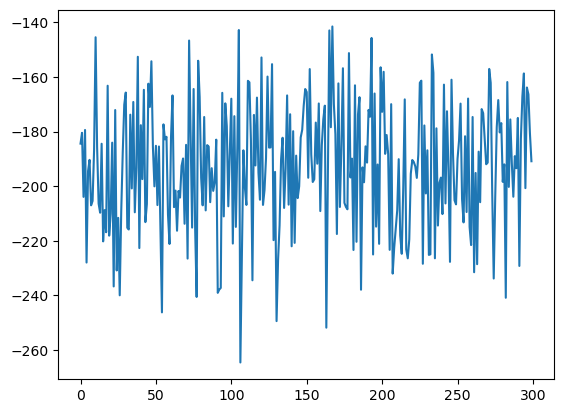

In [ ]:
plt.plot(k)